# Knowledge Base | Articles search

## Need for a knowledge base

At the origin of this project is my experience of two very different type of consulting firms. In 2021, I spent 4 months as a visiting associate at the [Boston Consulting Club](https://www.bcg.com/belgium). With little technical background, I was wuickly able to deliver complex pricing analysis, industry benchmarking and positioning studies. The reason for this is that BCG had an extensive and well structured knowledge base (slides, articles, and market research). I was able to find the right information in a matter of minutes.

A year later, I joined a small consulting called [Reacfin](https://www.reacfin.com/) specialized in actuarial sciences and risk management. There knowledge was not articulated in a structured way. Luckily my colleagues were highly knowledgeable and took the time to bring me up to speed. However, I could not help but think that the firm was missing out on a lot of potential by not having a knowledge base.

I pursued my research on the topic and found out that the knowledge base is a key factor of success for consulting firms. However, accumulating knowledge is not enough. The knowledge base must be structured and easily accessible.

*Supporting articles on the problematic:*

- [Dunford, R. (2000), "Key challenges in the search for the effective management of knowledge in management consulting firms", Journal of Knowledge Management, Vol. 4 No. 4, pp. 295-302.](https://doi.org/10.1108/13673270010379849)
- [Werr, A., & Stjernberg, T. (2003). Exploring Management Consulting Firms as Knowledge Systems. Organization Studies, 24(6), 881-908.](https://doi.org/10.1177/0170840603024006004)
- [Sarvary, M. (1999). Knowledge Management and Competition in the Consulting Industry. California Management Review, 41(2), 95-107.](https://doi.org/10.2307/41165988)


## Project overview

Until now I had not found a satisfactory way to navigate existing documentation. For example, a keywords search would require a standardisation of the vocabulary across the firm, which is time consuming, arbitrary, and not flexible. However, we discovered the concept of [semantic search](https://www.sbert.net/examples/applications/semantic-search/README.html) which is a search technique that takes into account the meaning and context of words. This is exactly what we need to navigate our knowledge base intuitively.

This first notebook will focus on the implementation of a semantic search engine for scientific articles. This is a proof of concept for a larger project including notebooks and functions to support the technical profiles at Reacfin. Here are the different steps of the notebook:
1. [Abstract search](#1.-Abstract-search): we will extract the abstracts of our knowledge base, then tokenize and vectorize them. We will then use the vectorized abstracts to find the most similar abstracts to a given query.
2. [Full text retrieval](#2.-Full-text-retrieval): we will use the result of the abstracts search as index to retrieve the full text of the most relevant articles.
3. [Knowledge space](#3.-Knowledge-space): we will use the abstracts embeddings to identify clusters of articles and visualize them in a 2D space. This will help us understand the structure of our knowledge base and navigate it intuitively.
4. [Full text search](#4.-Full-text-search): we will use the full text of the articles to find the most relevant chunks of text to a given query. This will allow us to find detailed information on a specific topic. This can also be used as the first step for a RAG chatbot.



---
---
*This is the first notebook of a series of 4. The other notebooks are:*
- *`Knowledge Base | Notebooks search`: Identify relevant notebooks based on Markdown cells*
- *`Knowledge Base | Functions search`: Identify relevant functions based on Docstrings*
- *`Knowledge Base | RAG chatbot`: Augment an open-source LLM with the knowledge retrieved*


# 1. Abstract search
*back to [Project Overview](#project-overview)*


First, we'll need to create our knowledge base. `Reacfin` shared a repository of about 40 articles. For the preprocessing, we will:
- Extract all articles from the ZIP file and keep the PDFs of a certain size only
- Extract the abstracts from the articles using the `pdfminer` library
- Make a match between the abstracts, the articles, and the test queries to set up a validation framework
- Tokenize the abstracts
- Vectorize the abstracts
- Use the vectorized abstracts to find the most similar abstracts to a given query

In [ ]:
# Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

## 1.1. Extract articles from ZIP file

We will use the `zipfile` library to extract the articles from the ZIP file and the `os` and `shutil` libraries to move the PDFs to the original directory and delete the temporary directory. Then, we will use the `PyMuPDF` (imported as `fitz`) library to filter out the PDFs that are too large for our proof of concept (it prevents having too many chunks of the same pdf in our vectorspace in the upcoming [Full text search](#4.-Full-text-search)). We will keep the PDFs that are less than 30 pages long.

In [11]:
from zipfile import ZipFile
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fitz

In [12]:
def extract_zip(from_dir, to_dir, folder_name='Academic', verbose=True):
    """Extract the files from the zip files (can be multiple) and move them to the chosen folder

    Parameters
    ----------
    from_dir : str
        Directory where the zip files are located
    to_dir : str
        Directory where the labels will be extracted
    verbose : bool, optional
        Print the details of the execution, by default True

    Returns
    -------
    None
        The labels are extracted and moved to the chosen folder
    """
    all_files = [file for file in os.listdir(from_dir) if ".zip" in file]
    i = 0
    for file in all_files:
        if verbose:
            print(f"Extracting: {file}")
        with ZipFile(from_dir+"/"+file, "r") as zipObj:
            # Keep only the pdf files to extract
            all_objects = zipObj.namelist()
            all_objects = [x for x in all_objects if x.endswith(".pdf")]
            # Extract all the chosen files
            for object in all_objects:
                zipObj.extract(object, to_dir)
        i += 1
    if verbose:
        print(f"{i} files extracted")

    # Delete zip files
    for file in all_files:
        os.remove(from_dir+"/"+file)

    # Move all labels to the root folder
    for file in os.listdir(to_dir+f"/{folder_name}"):
        shutil.move(os.path.join(to_dir+f"/{folder_name}", file), to_dir)

    # Delete empty folder
    os.rmdir(to_dir+f"/{folder_name}")
    if verbose:
        print("Repository cleaned")

In [9]:
extract_zip(
    from_dir = 'kb_articles',
    to_dir='kb_articles', # same directory
    folder_name='Academic', # folder name where the labels are extracted
    verbose=True)

Extracting: articles.zip
1 files extracted
Repository cleaned


We will now make a first structure of our knowledge base with the title, page count, abstracts (empty for now), and the path to the PDFs. We see that the `doc.metadata` method of the `fitz` library allows us to extract a lot of information but for a few articles only so we will fetch the information manually instead.

In [33]:
pd.set_option('display.max_columns', None)
kb_articles = pd.DataFrame(columns=['title', 'pages', 'abstract', 'path'])


def structure_kb(kb_dir, index, verbose=True):
    """Structure the knowledge base into a dataframe with the following columns: title, pages, abstract, path

    Parameters
    ----------
    kb_dir : str
        Directory where the knowledge base is located
    index : pd.core.frame.DataFrame or str
        Path to the dataframe or the dataframe itself
    verbose : bool, optional
        Print the details of the execution, by default True

    Returns
    -------
    pd.core.frame.DataFrame
        Dataframe with the knowledge base
    """
    if type(index) != pd.core.frame.DataFrame:
        try:
            index = pd.read_excel(index)
        except:
            index = pd.read_csv(index)
    # Crawl the knowledge base and extract the metadata
    for file in os.listdir(kb_dir):
        if file.endswith(".pdf"):
            path = os.path.join(kb_dir, file)
            doc = fitz.open(path)
            # Append the metadata to the dataframe
            if path not in index.path.values:
                index.loc[len(index)] = [file.removesuffix('.pdf'), len(doc), None, path]
                if verbose:
                    print(f"Title: {file.removesuffix('.pdf')}")
                    print(f"Pages: {len(doc)}")
                    print(f"Path: {path}")
    return index

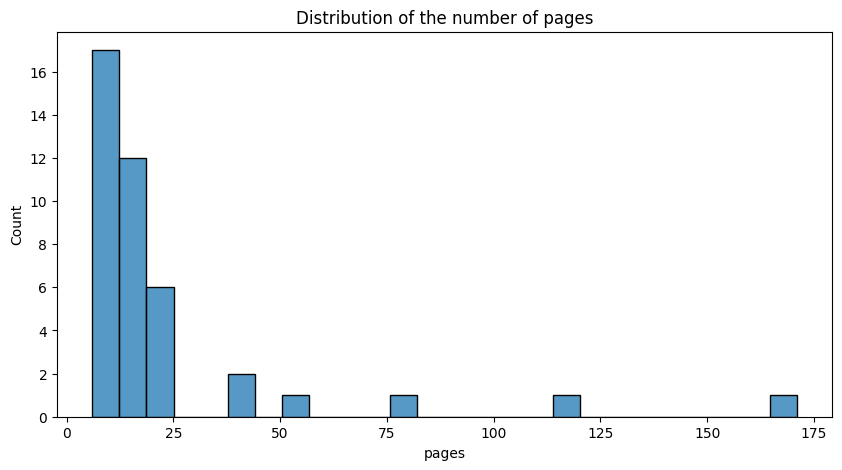

Proportion of articles with more than 30 pages: 14.63%
35 articles indexed in the knowledge base


In [45]:
kb_articles = structure_kb("kb_articles", kb_articles, verbose=True)
plt.figure(figsize=(10, 5))
sns.histplot(kb_articles.pages)
plt.title("Distribution of the number of pages")
plt.show()
# It seems that the majority of the articles have less than 30 pages which should be a good cut-off point
print(f"Proportion of articles with more than 30 pages: {len(kb_articles[kb_articles.pages > 30])/len(kb_articles):.2%}")

# Remove articles with more than 30 pages
kb_articles_poc = kb_articles[kb_articles.pages <= 30]
kb_articles_poc.reset_index(inplace=True, drop=True)
kb_articles_poc.to_excel("kb_articles/AAA_index.xlsx", index=False)
print(f"{len(kb_articles_poc)} articles indexed in the knowledge base")

# 2. Full text retrieval
*back to [Project Overview](#project-overview)*

# 3. Knowledge space
*back to [Project Overview](#project-overview)*

# 4. Full text search
*back to [Project Overview](#project-overview)*

Thank you for reading this notebook. I hope you enjoyed it and that it gave you some insights into the potential of semantic search for knowledge management.

---
Mathieu Demarets (mathieu.demarets@edu.vlerick.com)